# Final Project: Image Classification for Aerial Image Data.
***
## Table of Contents
1. [Abstract](#Abstract)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Models used](#Models-used)
4. [Discussion](#Discussion)
5. [Conclusions](#Conclusions)

## Abstract

This notebook addresses a multilabel classification problem using [AiTLAS Semantic Data Catalog](http://eodata.bvlabs.ai/#/dataset/aid). As preliminary analysis a CNN was tested to see its performance influenced by the unbalanced dataset. After, some of the preprocessing steps taken were image resizing and data balancing. 

While the dataset was fairly balanced, the number of images among classes ranged between 220 - 420, meaning that its smallest class has about 50% of the amount of pictures the largest one has. This difference played against the CNN performance having very low accuracy. To improve the CNNs performance, image resizing was performed as well as image balancing. From 10000 images, the data was narrowed to to 4500,  150 pictures per class, after training the model, the model didn't change much in accuracy. Steps that are yet to be tested are data augmentation and transfer learning using EfficientNetB3.

Since the models are still under development, is not recommended to use them given the current low accuracies. Once this model could be applied for land cover/ land use analysis and scene classification.

## Data Preprocessing

### About the data
#### Source
@article{xia2017aid, <br>
	title={AID: A benchmark data set for performance evaluation of aerial scene classification},<br>
	author={Xia, Gui-Song and Hu, Jingwen and Hu, Fan and Shi, Baoguang and Bai, Xiang and Zhong, Yanfei and Zhang, Liangpei and Lu, Xiaoqiang},<br>
	journal={IEEE Transactions on Geoscience and Remote Sensing},<br>
	volume={55},<br>
	number={7},<br>
	pages={3965--3981},<br>
	year={2017},<br>
	publisher={IEEE}
}

#### Description 
The Aerial Image Dataset (AID) is a large-scale aerial image dataset generated by collecting sample images from Google Earth imagery. Its goal is to advance the state-of-the-arts in scene classification of remote sensing images for land cover, land use, image classification, scene classification. The dataset contains a total 30 labels distributed in 10000 annotated RGB images with a size of 600x600 in a .jpg format.

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
from random import randint
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers
from tensorflow.keras.models import Model
%matplotlib inline

### For CNNs without image balancing

In [2]:
#Create a class list and count the items
path = r'C:\Users\DSMLAzure\Documents\The-Deep-Learning-Workshop-master\Aerial Image Dataset\AID'
classes = sorted(os.listdir(path))

In [3]:
#Create a list of image directories and its corresponding labels
filepaths = []
labels = [] 
for klass in classes:
    classpath = os.path.join(path, klass)
    images = sorted(os.listdir(classpath))
    for img in images:
        imgpath = os.path.join(classpath, img)
        filepaths.append(imgpath)
        labels.append(klass)

In [4]:
#Create a df of image path and class labels
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
df

filepaths   labels
0     C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
1     C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
2     C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
3     C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
4     C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
...                                                 ...      ...
9995  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9996  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9997  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9998  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9999  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct

[10000 rows x 2 columns]

In [5]:
#Get the classes and count them
classes = sorted(list(df['labels'].unique()))
class_count = len(classes)

#Print the image classes, total classes in the datasets and total number of imgs
print('Image classes:\n', classes, '\n')
print('Number of classes in the dataset: ', class_count)
print('Total number of images: ', len(df['labels']), '\n')

#Image distribution by class
countlist = []
classlist = []
groups = df.groupby('labels')
for label in classes:
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    labels_dist = pd.DataFrame({'Label': classlist, 'Counts': countlist})

Image classes:
 ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct'] 

Number of classes in the dataset:  30
Total number of images:  10000 



In [6]:
#Image distribution by class, sorted
labels_dist = labels_dist.sort_values(by=['Counts'], ascending=False)[['Label','Counts']]
labels_dist

Label  Counts
29            Viaduct     420
19               Pond     420
23              River     410
8    DenseResidential     410
3               Beach     400
12         Industrial     390
17            Parking     390
20               Port     380
18         Playground     370
10           Farmland     370
28       StorageTanks     360
0             Airport     360
4              Bridge     360
16               Park     350
7          Commercial     350
15           Mountain     340
26             Square     330
1            BareLand     310
25  SparseResidential     300
9              Desert     300
24             School     300
14  MediumResidential     290
27            Stadium     290
22             Resort     290
13             Meadow     280
21     RailwayStation     260
5              Center     260
11             Forest     250
6              Church     240
2       BaseballField     220

In [7]:
#Average height and width of the images
ht=0
wt=0
for i in range (len(df)):
    fpath = df['filepaths'].iloc[i]
    img = plt.imread(fpath)
    shape = img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//10000, ' average width= ', wt//10000, 'aspect ratio= ', ht/wt)

average height=  600  average width=  600 aspect ratio=  1.0


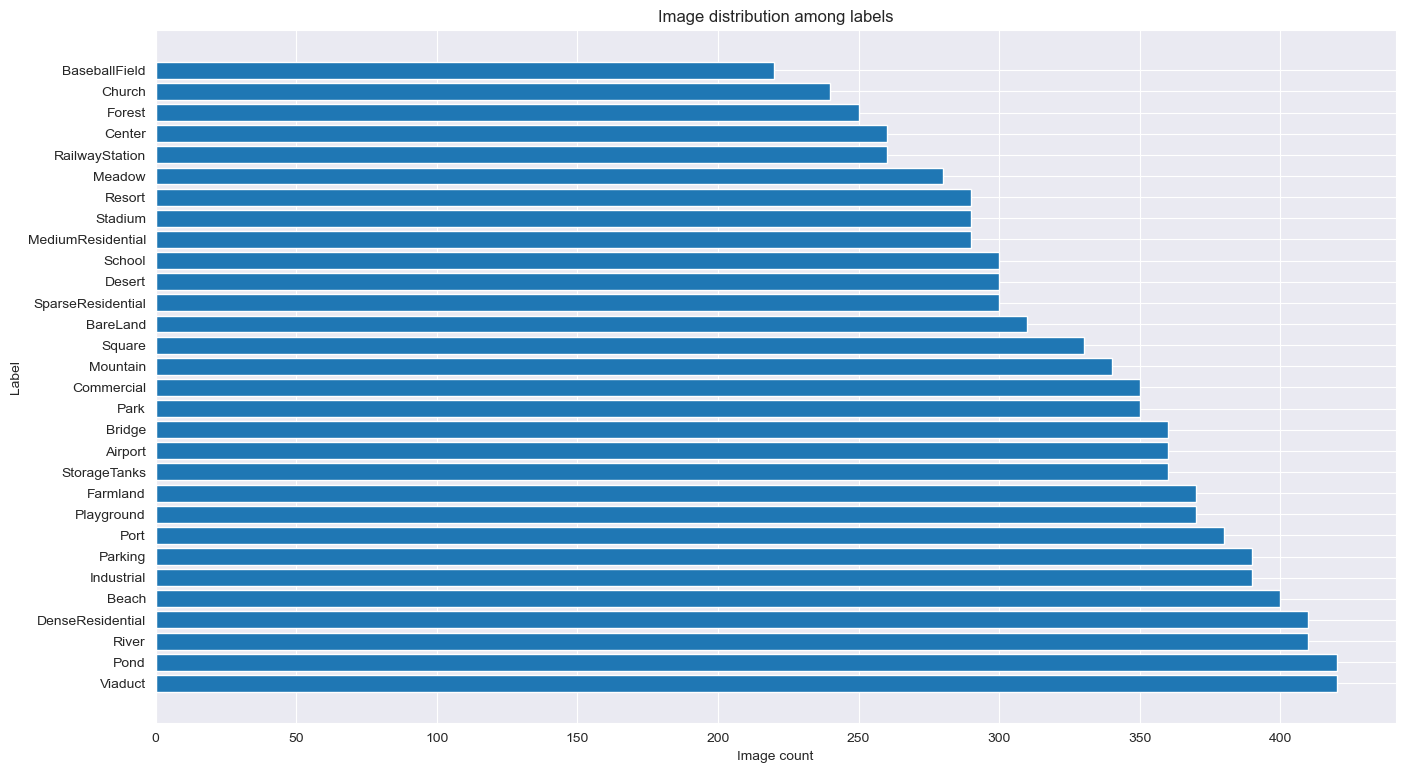

In [8]:
#Plot the image distribution in a bar plot
fig = plt.figure(figsize = (16, 9))

# creating the bar plot
plt.barh(labels_dist['Label'],labels_dist['Counts'])
plt.xlabel('Image count')
plt.ylabel('Label')
plt.title('Image distribution among labels')
plt.show()

>As stated in the [About the data](#About-the-data) section, this dataset is comprised by 10,000 pictures, distributed among 30 different labels. The average size calculated confirms that every single images has a size of 600x600, which means that there's no need for resizing, however, for faster training the images will be shrinked to 200x200. Overall, the dataset is fairly balanced, as we move forward to the DL modeling, we'll start with preliminary analysis implementing a CNN without image balancing to assess the effects in the models performance. 

In [9]:
class_label = {i:class_name for i, class_name in enumerate(classes)}
class_label

{0: 'Airport',
 1: 'BareLand',
 2: 'BaseballField',
 3: 'Beach',
 4: 'Bridge',
 5: 'Center',
 6: 'Church',
 7: 'Commercial',
 8: 'DenseResidential',
 9: 'Desert',
 10: 'Farmland',
 11: 'Forest',
 12: 'Industrial',
 13: 'Meadow',
 14: 'MediumResidential',
 15: 'Mountain',
 16: 'Park',
 17: 'Parking',
 18: 'Playground',
 19: 'Pond',
 20: 'Port',
 21: 'RailwayStation',
 22: 'Resort',
 23: 'River',
 24: 'School',
 25: 'SparseResidential',
 26: 'Square',
 27: 'Stadium',
 28: 'StorageTanks',
 29: 'Viaduct'}

In [10]:
#Load images and labels into arrays
def load_data():
    images = []
    labels = []

    for lbl in df['labels']:
        for key, value in zip(class_label, class_label.values()):
            if lbl == value:
                labels.append(key)

    for i in range (len(df)):
        fpath = df['filepaths'].iloc[i]
        img = cv2.imread(fpath)
        img = cv2.resize(img,(200,200))
        images.append(img)

    Images = np.array(images)
    Labels = np.array(labels)
    return shuffle(Images, Labels, random_state=123)

In [11]:
Images, Labels = load_data()

In [12]:
Images.shape

(10000, 200, 200, 3)

In [13]:
Labels.shape

(10000,)

In [14]:
def get_classlabel(class_code):
    labels = class_label
    return labels[class_code]

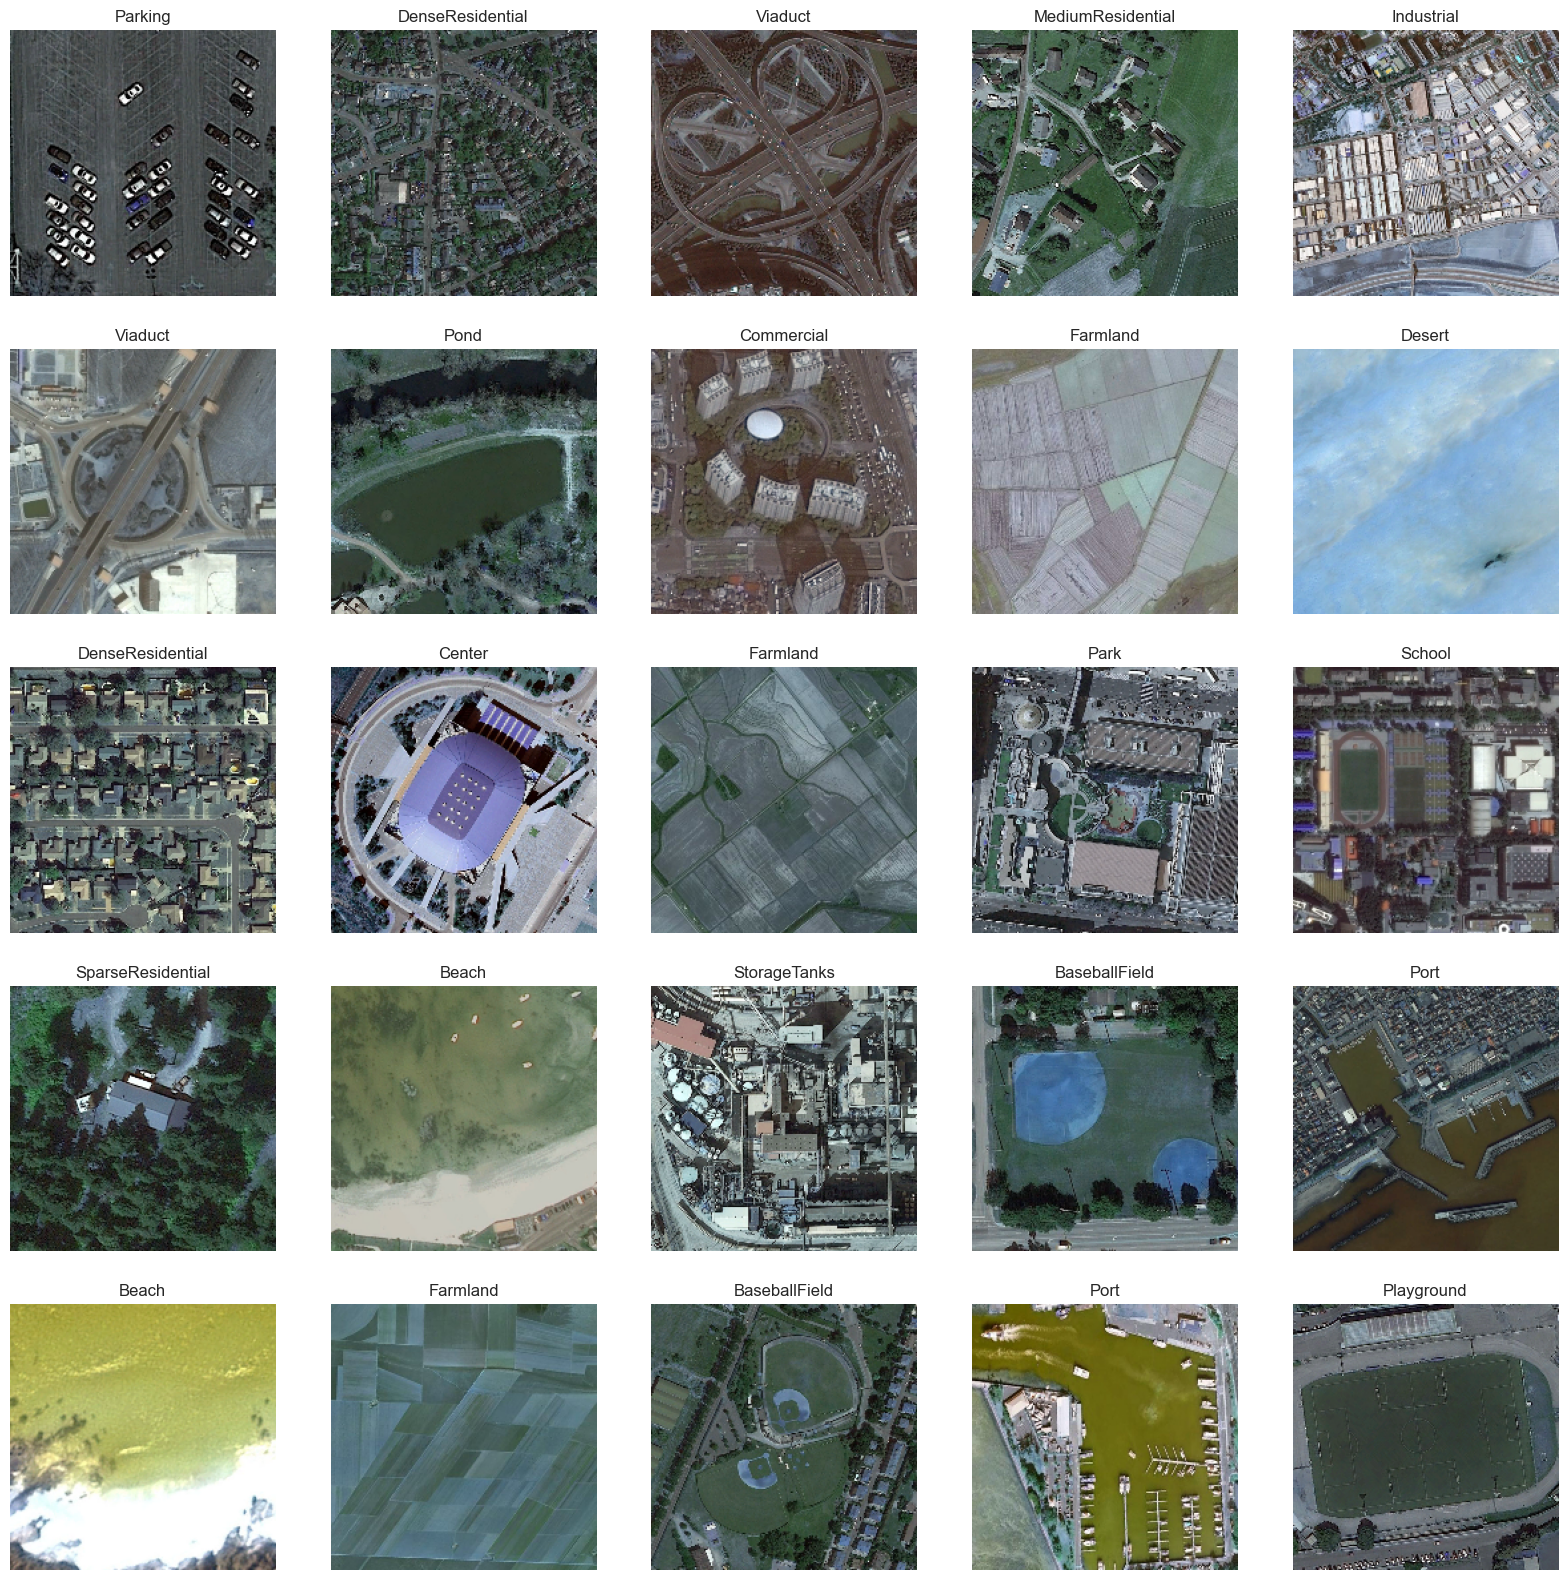

In [15]:
plt.figure(figsize=(20, 20))
for i in range(25):
    rnd_number = randint(0,len(Images))
    plt.subplot(5, 5, i + 1)
    plt.imshow(Images[rnd_number])
    plt.title(get_classlabel(Labels[rnd_number]))
    plt.axis('off')

>In the plot above we can see a sample of the different images with their respective labels

In [16]:
#Split train,test,valid images
train_img_un, remainder = train_test_split(Images, train_size=.9, random_state=123)
valid_img_un, test_img_un = train_test_split(remainder, train_size=.5, random_state=123)     
print('train_img_un lenght: ', train_img_un.shape, '  test_img_un length: ', test_img_un.shape, '  valid_img_un length: ', valid_img_un.shape)

train_img_un lenght:  (9000, 200, 200, 3)   test_img_un length:  (500, 200, 200, 3)   valid_img_un length:  (500, 200, 200, 3)


In [17]:
#Split train,test,valid labels
train_lbl_un, remainder = train_test_split(Labels, train_size=.9, random_state=123)
valid_lbl_un, test_lbl_un = train_test_split(remainder, train_size=.5, random_state=123)     
print('train_lbl_un lenght: ', train_lbl_un.shape, '  test_lbl_un length: ', test_lbl_un.shape, '  valid_lbl_un length: ', valid_lbl_un.shape)

train_lbl_un lenght:  (9000,)   test_lbl_un length:  (500,)   valid_lbl_un length:  (500,)


[Go to CNNs without balancing](#CNN-without-image-balancing)

## Trim the dataseto to balance the class samples

In [18]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=150 # since each class has more than150 images all classes will be trimmed to have 150 images per class
min_samples=50
column='labels'
balanced_df = trim(df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  150  and the minimum samples in any class is  50


In [19]:
balanced_df

filepaths   labels
165   C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
251   C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
11    C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
134   C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
41    C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Airport
...                                                 ...      ...
9989  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9685  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9789  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9764  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct
9811  C:\Users\DSMLAzure\Documents\The-Deep-Learning...  Viaduct

[4500 rows x 2 columns]

In [20]:
#Balanced mage distribution by class
classes_b = sorted(list(balanced_df['labels'].unique()))
class_count_b = len(classes_b)

countlist_b = []
classlist_b = []
groups_b = balanced_df.groupby('labels')
for label in classes_b:
    group_b = groups_b.get_group(label)
    countlist_b.append(len(group_b))
    classlist_b.append(label)
    labels_dist_b = pd.DataFrame({'Label': classlist_b, 'Counts': countlist_b})
labels_dist_b

Label  Counts
0             Airport     150
1            BareLand     150
2       BaseballField     150
3               Beach     150
4              Bridge     150
5              Center     150
6              Church     150
7          Commercial     150
8    DenseResidential     150
9              Desert     150
10           Farmland     150
11             Forest     150
12         Industrial     150
13             Meadow     150
14  MediumResidential     150
15           Mountain     150
16               Park     150
17            Parking     150
18         Playground     150
19               Pond     150
20               Port     150
21     RailwayStation     150
22             Resort     150
23              River     150
24             School     150
25  SparseResidential     150
26             Square     150
27            Stadium     150
28       StorageTanks     150
29            Viaduct     150

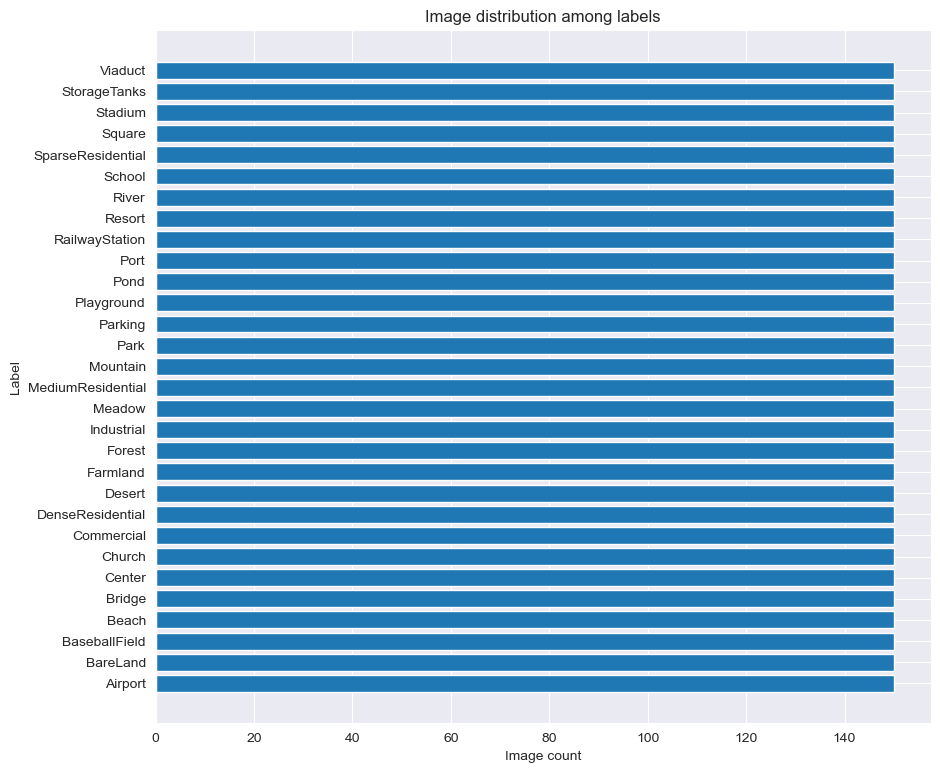

In [21]:
#Plot the image distribution in a bar plot
fig = plt.figure(figsize = (10, 9))

# creating the bar plot
plt.barh(labels_dist_b['Label'],labels_dist_b['Counts'])
plt.xlabel('Image count')
plt.ylabel('Label')
plt.title('Image distribution among labels')
plt.show()

In [22]:
#Load images and labels into arrays
def load_data1():
    images = []
    labels = []

    for lbl in balanced_df['labels']:
        for key, value in zip(class_label, class_label.values()):
            if lbl == value:
                labels.append(key)

    for i in range (len(balanced_df)):
        fpath = balanced_df['filepaths'].iloc[i]
        img = cv2.imread(fpath)
        img = cv2.resize(img,(200,200))
        images.append(img)

    Images_b = np.array(images)
    Labels_b = np.array(labels)
    return shuffle(Images_b, Labels_b, random_state=123)

In [23]:
bal_images, bal_labels = load_data1()

In [24]:
#Split train,test,valid images
train_img_bal, test_img_bal = train_test_split(bal_images, train_size=.9, random_state=123)   
print('train_img_bal lenght: ', train_img_bal.shape, '  test_img_un length: ', test_img_bal.shape)

train_img_bal lenght:  (4050, 200, 200, 3)   test_img_un length:  (450, 200, 200, 3)


In [25]:
#Split train,test,valid labels
train_lbl_bal, test_lbl_bal = train_test_split(bal_labels, train_size=.9, random_state=123)  
print('train_lbl_bal lenght: ', train_lbl_bal.shape, '  test_lbl_bal length: ', test_lbl_bal.shape)

train_lbl_bal lenght:  (4050,)   test_lbl_bal length:  (450,)


[Go to CNN with balanced dataset](#CNN-with-balanced-dataset)

## Deep Learning Models used
* Develop code to train various models on your data. 
* Make a subsection for each model
    * provide a written description of what you are doing, 
    * note choices of architecture and hyperparameters. 
* Provide an assessment with code and written explanations of how well each model is able to achieve the desired outcomes, 
    * quantitative metrics (accuracy, recall, precision, etc.) wherever possible **(model dependent)**
* write code to generate a number of plots and other visualizations, and write words to discuss what these show. 
* Investigate how well each model performs on validation data to select the best choice of architecture and hyperparameters.

### CNN without image balancing

In [26]:
un_model = keras.Sequential([
    layers.InputLayer(input_shape = [200, 200 , 3]),
    
    layers.Conv2D(filters = 200,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.Conv2D(filters = 180,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2), strides = 2),
    
    layers.Conv2D(filters = 140,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
        layers.Conv2D(filters = 100,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
        layers.Conv2D(filters = 50,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2), strides = 2),
    
    layers.Conv2D(filters = 16,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = 2, strides = 2),
    
    layers.Flatten(),
    layers.Dense(units = 32, activation = "relu"),
    layers.Dense(units = 30, activation = "softmax")    
])

un_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 180)     324180    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 180)    0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 140)     226940    
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 100)     126100    
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 50)      45050     
                                                        

In [27]:
un_model.compile(
    optimizer = keras.optimizers.Adam(epsilon = 0.01),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [28]:
unbalanced_model = un_model.fit(
    train_img_un, train_lbl_un,
    epochs = 10)

Epoch 1/10
282/282 [==============================] - 69s 220ms/step - loss: 3.4406 - accuracy: 0.0368
Epoch 2/10
282/282 [==============================] - 61s 217ms/step - loss: 3.3879 - accuracy: 0.0439
Epoch 3/10
282/282 [==============================] - 61s 216ms/step - loss: 3.3638 - accuracy: 0.0478
Epoch 4/10
282/282 [==============================] - 61s 217ms/step - loss: 3.1471 - accuracy: 0.1232
Epoch 5/10
282/282 [==============================] - 61s 217ms/step - loss: 2.6441 - accuracy: 0.2364
Epoch 6/10
282/282 [==============================] - 61s 217ms/step - loss: 2.1636 - accuracy: 0.3509
Epoch 7/10
282/282 [==============================] - 61s 217ms/step - loss: 1.7568 - accuracy: 0.4692
Epoch 8/10
282/282 [==============================] - 61s 217ms/step - loss: 1.3411 - accuracy: 0.5863
Epoch 9/10
282/282 [==============================] - 61s 217ms/step - loss: 1.0446 - accuracy: 0.6766
Epoch 10/10
282/282 [==============================] - 61s 217ms/step - l

>For this preliminary analysis, we can see that the model obtained a loss: 0.7998 - accuracy: 0.7468. While the accuracy is doing a decent job, there's also a considerable loss. There might be errors in the prediction of part of the data.

### Balanced dataset

In [45]:
balanced_model = keras.Sequential([
    layers.InputLayer(input_shape = [200, 200 , 3]),
    
    layers.Conv2D(filters = 200,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.Conv2D(filters = 180,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2), strides = 2),
    
    layers.Conv2D(filters = 140,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
        layers.Conv2D(filters = 100,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
        layers.Conv2D(filters = 50,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2), strides = 2),
    
    layers.Conv2D(filters = 16,
                  kernel_size = (3, 3),
                  padding = 'same',
                  activation = 'relu'),
    layers.MaxPool2D(pool_size = 2, strides = 2),
    
    layers.Flatten(),
    layers.Dense(units = 32, activation = "relu"),
    layers.Dense(units = 30, activation = "softmax")    
])

balanced_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 200, 200, 200)     5600      
                                                                 
 conv2d_19 (Conv2D)          (None, 200, 200, 180)     324180    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 100, 100, 180)    0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 100, 100, 140)     226940    
                                                                 
 conv2d_21 (Conv2D)          (None, 100, 100, 100)     126100    
                                                                 
 conv2d_22 (Conv2D)          (None, 100, 100, 50)      45050     
                                                      

In [46]:
balanced_model.compile(
    optimizer = keras.optimizers.Adam(epsilon = 0.01),
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [47]:
balanced_model = balanced_model.fit(
    train_img_bal, train_lbl_bal,
    epochs = 10
)

Epoch 1/10
127/127 [==============================] - 30s 232ms/step - loss: 3.5886 - accuracy: 0.0277
Epoch 2/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4013 - accuracy: 0.0348
Epoch 3/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4013 - accuracy: 0.0291
Epoch 4/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4012 - accuracy: 0.0326
Epoch 5/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4012 - accuracy: 0.0311
Epoch 6/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4011 - accuracy: 0.0326
Epoch 7/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4011 - accuracy: 0.0321
Epoch 8/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4011 - accuracy: 0.0328
Epoch 9/10
127/127 [==============================] - 27s 216ms/step - loss: 3.4011 - accuracy: 0.0328
Epoch 10/10
127/127 [==============================] - 27s 216ms/step - l

>The model was expected to perform better, however it was the opposite. We'll perform other techniques to obtain better performance. 

### Using balanced data and Data augmentation

In [36]:
train_df, dummy_df=train_test_split(balanced_df, train_size=.9, shuffle=True, random_state=123)
valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123)     
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  4050   test_df length:  225   valid_df length:  225


In [37]:
batch_size=30 
train_img_gen = ImageDataGenerator(horizontal_flip=True,
                                     rotation_range=20, 
                                     width_shift_range=.2,
                                     height_shift_range=.2,
                                     zoom_range=.2 )
val_img_gen = ImageDataGenerator()

train_data_gen = train_img_gen.flow(train_img_bal, train_lbl_bal, batch_size=batch_size)

val_data_gen = val_img_gen.flow(train_img_bal, train_lbl_bal, batch_size=batch_size)

In [38]:
img_size=(200,200)
batch_size=30 
train_img_gen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=20, 
                                   width_shift_range=.2,
                                   height_shift_range=.2, 
                                   zoom_range=.2 )
test_val_img_gen = ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_data_gen = train_img_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_data_gen = test_val_img_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_data_gen = test_val_img_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_data_gen.class_indices.keys())
class_indices=list(train_data_gen.class_indices.values())
class_count=len(classes)
labels=test_data_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 4050 validated image filenames belonging to 30 classes.          for train generator 
Found 225 validated image filenames belonging to 30 classes.           for valid generator 
Found 225 validated image filenames belonging to 30 classes.           for test generator 
test batch size:  75   test steps:  3  number of classes :  30


In [ ]:
aug_images, aug_labels = train_data_gen.next()

In [ ]:
aug_images

In [ ]:
aug_labels[0]

### EfficientNetB3

In [39]:
img_shape=(200, 200, 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=False
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 200, 200, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['normalization[0][0

In [40]:
# New model
model= tf.keras.Sequential([base_model,
                            layers.Flatten(),
                            layers.Dense(1024, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(512, activation='relu'),
                            layers.Dropout(0.5),
                            layers.Dense(128, activation='relu'),
                            layers.Dense(2, activation='softmax')])
    
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 flatten_3 (Flatten)         (None, 1536)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [42]:
history=model.fit(x=train_data_gen,  epochs=15, verbose=1, validation_data=valid_data_gen,
               validation_steps=None,  shuffle=False)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "C:\Miniconda\envs\UL\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Miniconda\envs\UL\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Miniconda\envs\UL\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
      self.io_loop.start()
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Miniconda\envs\UL\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Miniconda\envs\UL\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Miniconda\envs\UL\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\kernelbase.py", line 539, in execute_request
      self.do_execute(
    File "C:\Miniconda\envs\UL\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Miniconda\envs\UL\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Miniconda\envs\UL\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-42-6cbf282d5f41>", line 1, in <cell line: 1>
      history=model.fit(x=train_data_gen,  epochs=15, verbose=1, validation_data=valid_data_gen,
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\losses.py", line 1789, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "C:\Miniconda\envs\UL\lib\site-packages\keras\backend.py", line 5098, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[30,2] labels_size=[30,30]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_39412]

### Discussion


|          | **Unbalanced data** | **Balanced data** |
|:--------:|:-------------------:|:-----------------:|
| Accurary | 0.7468              |                   |
| Loss     | 0.7998              |                   |

The different approaches showed mixed results. At any case, both models didn't perform as expected, therefore other techniques suchas data augmentation and transfer learning should be tested to see better results.

### Conclusions
At the stage of where the model is at right is not recommeded for use, the accuracies are too low. Next steps recommended for this use case is to perform Data Augmentation and make use of the benefits of transfer learning. Other points that may have influenced the results are thee size of the final training data sets and the training time. 